# 적외선 필터 데이터 실험 보고서
- 실험 수행자 : 고현웅 (전북대 자율로봇 연구실)
- 실험 수행일 : 2020년 8월 10일

## 1. 데이터 경로 설정
- 본인(고현웅)은 리눅스 컴퓨터에서 작업을 수행하고 있으나, 윈도우에서도 실험할 수 있게 경로를 설정함
- 아래 root_dir을 프로젝트 루트 경로로 설정하면 직접 이 실험을 수행해 볼 수 있음

In [1593]:
# project root 경로 설정

import platform


_ = '\\' if platform.system() == 'Windows' else '/'
root_dir = '/home{_}gusdnd852{_}Github{_}strabismus-recognition{_}'.format(_=_)
if root_dir[len(root_dir) - 1] != _: root_dir += _

## 2. 데이터 로딩
- 적외선 필터 데이터가 있는 데이터만 활용하며, 적외선 필터 데이터가 없으면 제외함
- 개별 환자의 동공 움직임 패턴을 외우는 문제를 방지하기 위해, 한 환자당 하나의 데이터만 넣음
- 마비사시는 예측이 어려울 것으로 보이며, 우선은 적외선 필터 데이터 실험만 수행하였음.

In [1594]:
import pandas as pd
import numpy as np
import os

In [1595]:
# file type에 따라 다른 데이터에 접근

def load_data(classes, max_len, label, short:bool=False):
    file_type = 'fixations' if short else 'all_gaze' 
    raw_data_dir = root_dir + 'data{_}{c}{_}'.format(_=_, c=classes)
    listdir = [_ for _ in os.listdir(raw_data_dir) if file_type in _]
    
    dataset, existing_names = [], ['']
    for filename in listdir:
        file = pd.read_csv(raw_data_dir + filename)
        MEDIA_ID = file['MEDIA_ID'].unique().tolist()

        if len(MEDIA_ID) < 2:
            # 적외선 필터 검사를 진행하지 않은 데이터
            continue  # 데이터 목록에서 제외합니다.
            
        if filename[:3] in existing_names:
            continue # 환자당 데이터 1개씩만 포함
        
        file = file[file['MEDIA_ID'] == MEDIA_ID[-1]]  
        # 적외선 필터 데이터만 로드
        
        data = np.c_[file.LPCX,  file.RPCX, file.LPV, file.RPV]
        columns = ['LPCX', 'RPCX', 'LPV', 'RPV']        
        data = pd.DataFrame(data=data, columns=columns)
        
        # 데이터 딕셔너리 구성
        label = np.array(label)
        data_dict = {'data':data, 'label': label}
        dataset.append(data_dict)
        existing_names.append(filename[:3])
        
    return dataset    

In [1629]:
normal = load_data('normal', max_len=1000, label=0)
exotropia = load_data('exotropia', max_len=1000, label=1)
esotropia = load_data('esotropia', max_len=1000, label=1)
# hypertropia = load_data('hypertropia', max_len=1000, label=3) 
# 상사시는 데이터 너무 없어서 제외

In [1628]:
"""
데이터의 형태는 아래와 같음

LPCX : 해당 타임스텝의 왼쪽 동공 좌표
RPCX : 해당 타임스텝의 오른쪽 동공 좌표
LPV : 해당 타임스텝의 왼쪽 동공이 유효여부 (카메라에 잡혔는지)
RPV : 해당 타임스텝의 오른쪽 동공이 유효여부 (카메라에 잡혔는지)
"""

normal[0]['data']

,LPCX,RPCX,LPV,RPV
0,0.37920,0.70308,1.0,1.0
1,0.37948,0.70324,1.0,1.0
2,0.37904,0.70290,1.0,1.0
3,0.37933,0.70324,1.0,1.0
4,0.37929,0.70321,1.0,1.0
...,...,...,...,...
968,0.34324,0.66812,0.0,0.0
969,0.34324,0.66812,0.0,0.0
970,0.34324,0.66812,0.0,0.0
971,0.34324,0.66812,0.0,0.0


## 3. 데이터 시각화 (EDA)
- 아래 데이터를 보면 알 수 있듯이 너무 노이즈가 심하기 때문에 정상, 내사시, 외사시의 패턴이 구분이 가지 않음
- 때문에 정상환자와 사시환자를 모델이 구별할 수 있게 노이즈를 제거하고 전처리를 해줄 필요가 있음

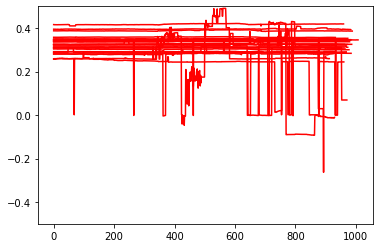

In [1566]:
from matplotlib import pyplot as plt

# 전처리 전 정상환자 시각화
outlier_threshold = 0.5
for i in normal:
    plt.plot(i['data']['RPCX'] - i['data']['LPCX'], c='r')
    
plt.ylim(-outlier_threshold, outlier_threshold)
plt.show()
plt.close()

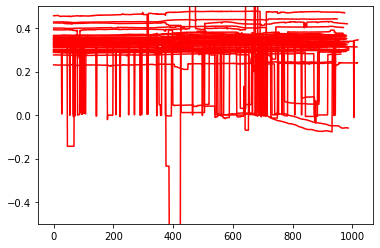

In [1567]:
from matplotlib import pyplot as plt

# 전처리 전 외사시 환자 시각화
outlier_threshold = 0.5
for i in exotropia:
    plt.plot(i['data']['RPCX'] - i['data']['LPCX'], c='r')

plt.ylim(-outlier_threshold, outlier_threshold)
plt.show()
plt.close()

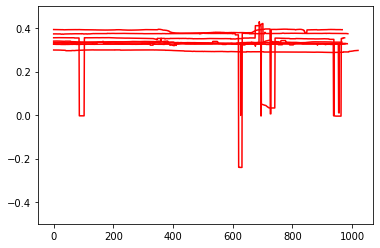

In [1568]:
from matplotlib import pyplot as plt

# 전처리 전 내사시 환자 시각화
outlier_threshold = 0.5
for i in esotropia:
    plt.plot(i['data']['RPCX'] - i['data']['LPCX'], c='r')

plt.ylim(-outlier_threshold, outlier_threshold)
plt.show()
plt.close()

## 4. 데이터 전처리
1. RX-LX 사용 : 사시라는 것은 양쪽눈이 벌어지는 것으로, RX - LX를 데이터로 사용 (상/하사시 환자는 거의 없으므로 Y좌표는 사용하지 않음)
2. Cleaning (1) : 이 때, 시선추적기가 제공하는 valid값을 확인해서 non valid한 타임스텝의 동공 좌표는 제거
3. Cleaning (2) : 만약 RX - LX가 그 평균보다 0.025 이상 높거나 작은 좌표는 너무 튀는 값이기 때문에 이상치로 규정하고 빼버림 
4. Mean Sampling : 개별 타임스텝마다 너무 데이터가 noisy하므로 10타임 스텝의 평균을 하나로 묶어서 평균을 냄.
5. Normalizing : 데이터에서 평균값을 빼서 평균이 0인 데이터 만듬. 이로 인해, 절대값을 취하면 정확히 절반이 부분의 봉우리가 위로 올라가서 외사시와 동일한 형태로 만들수 있음.
6. Abstract : 계산된 샘플링 값들에 절대값을 취해서 내사시와 외사시의 구분을 없애고 동일한 패턴으로 분류해냄.
7. Gaining : 좌표값이 너무 작으니 100을 곱하고 제곱해서 값을 증폭시켜서 모델이 보다 잘 학습할 수 있게 데이터를 변경함

In [1569]:
import pandas as pd
import numpy as np
import os


def preprocess(data, sampling_rate=10, outlier_threshold=0.025):
    lpcx, rpcx = data['data']['LPCX'], data['data']['RPCX']
    valid = data['data']['LPV'] + data['data']['RPV']
    diff = (rpcx - lpcx).tolist()
    mean = sum(diff) / len(diff)
    
    data_processed = []
    for i, (d, v) in enumerate(zip(diff, valid)):
        if d > mean + outlier_threshold:
            continue
        elif d < mean - outlier_threshold:
             continue
        elif v == 2:
            data_processed.append(d)
    
    data_processed = np.array(data_processed)
    mean = sum(data_processed) / (len(data_processed) + 1)
    data_normalized = np.array([d - mean for d in data_processed])
    
    data_sampled, sampling = [], []
    for i, d in enumerate(data_normalized):
        sampling.append(d)
        
        if len(sampling) > sampling_rate:
            del sampling[0]
        
        if i % sampling_rate == 0 and i > sampling_rate:
               data_sampled.append((sum(sampling) / len(sampling)))
    
    data_sampled = np.array(data_sampled)
    
    return {
        'data' : abs(data_sampled * 100 ** 2) ,
        'label' : data['label']
    }

In [1570]:
prep_normal = [preprocess(i) for i in normal if len(preprocess(i)['data']) != 0]
perp_exotropia = [preprocess(i) for i in exotropia if len(preprocess(i)['data']) != 0]
perp_esotropia = [preprocess(i) for i in esotropia if len(preprocess(i)['data']) != 0]

In [1601]:
# 각각 클래스 별 샘플의 갯수
# 전처리 과정에서 튀는 값이 너무 많은 데이터들은 알아서 빠짐

dataset = prep_normal + perp_exotropia + perp_esotropia

print('정상 : ', len(prep_normal))
print('외사시 : ', len(perp_exotropia))
print('내사시 : ', len(perp_esotropia))
print('종합 : ', len(dataset))

정상 :  29
외사시 :  42
내사시 :  7
종합 :  78


## 5. 전처리 후 시각화 (EDA)
- 정상환자는 RX-LX의 절대값이 매우 작지만, 사시 환자들은 RX-LX의 절대값이 큼
- 이 것을 기준으로 모델을 학습시켜서 사시/정상을 구분할 수 있을 것으로 기대

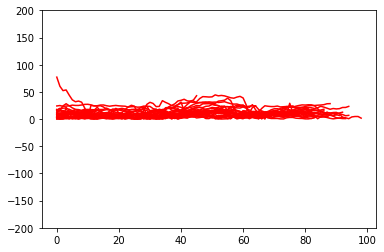

In [1602]:
from matplotlib import pyplot as plt

# 전 처리 후 정상환자 시각화
outlier_threshold = 200
for i in prep_normal:
    plt.plot(i['data'], c='r')
    
plt.ylim(-outlier_threshold, outlier_threshold)
plt.show()
plt.close()

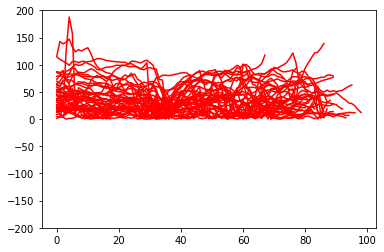

In [1603]:
from matplotlib import pyplot as plt

# 전처리 후 외사시 환자 시각화
outlier_threshold = 200
for i in perp_exotropia:
    plt.plot(i['data'], c='r')
    
plt.ylim(-outlier_threshold, outlier_threshold)
plt.show()
plt.close()

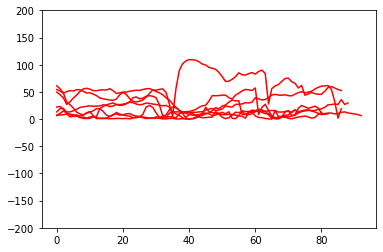

In [1604]:
from matplotlib import pyplot as plt

# 전처리 후 내사시 환자 시각화
outlier_threshold = 200
for i in perp_esotropia:
    plt.plot(i['data'], c='r')
    
plt.ylim(-outlier_threshold, outlier_threshold)
plt.show()
plt.close()

## 6. 패드 시퀀싱 (패딩 추가)
- 머신러닝 모델은 텐서를 입력으로 받아야하는데, 모든 데이터의 시퀀스 길이(타임스텝)이 다름
- 때문에 길이가 모자란 데이터들은 뒤쪽에 0을 채워넣어서 데이터의 길이를 모두 동일하게 맞춤

In [1605]:
def pad_sequence(dataset):
    data = [data['data'] for data in dataset]
    max_len = len(max(data, key=len))
    
    result_arr = []
    for data in dataset:
        label = data['label']
        data = data['data']
        
        zeros = np.zeros(max_len)
        zeros[:len(data)] = data
        result_arr.append({'data':zeros, 'label':label})
    
    return result_arr

In [1606]:
padded = pad_sequence(dataset)

## 7. 데이터셋 구성
- 데이터를 학습 / 테스트 데이터로 나눔
- 모델은 학습데이터만 보고 학습하며, 한번도 보지 않은 테스트 데이터를 맞춰야함
- 학습 / 테스트의 비율 (ratio)는 개발자가 마음대로 설정할 수 있게 함

In [1607]:
def make_dataset(dataset, ratio):
    split_point = int(ratio * len(dataset))
    train_dataset = dataset[:split_point]
    test_dataset = dataset[split_point:]

    train_feature, train_label = [], []
    test_feature, test_label = [], []
    
    for dataset in train_dataset:
        data = np.expand_dims(dataset['data'], axis=0)
        label = np.expand_dims(dataset['label'], axis=0)
        train_feature.append(data)
        train_label.append(label)
    
    for dataset in test_dataset:
        data = np.expand_dims(dataset['data'], axis=0)
        label = np.expand_dims(dataset['label'], axis=0)
        test_feature.append(data)
        test_label.append(label)
    
    train_feature = np.concatenate(train_feature, axis=0)
    train_label = np.concatenate(train_label, axis=0)
    test_feature = np.concatenate(test_feature, axis=0)
    test_label = np.concatenate(test_label, axis=0)
    
    return train_feature, train_label, test_feature, test_label

## 8. 모델링 & 실험
- 5가지 머신러닝 모델의 soft ensemble 모델을 구성하였음
- 학습데이터는 전체 데이터의 70%, 태스트 데이터는 전체 데이터의 30%를 사용함
- 각각 랜덤포레스트, 그래디언트부스팅, 서포트벡터머신, K최근접이웃, 가우시안 나이브베이즈 모델을 활용
- 직접 각각 모델을 돌려보고 가장 잘하는 5개의 모델을 선정한 것임.
- SVM은 파라미터의 영향을 크게 받기 때문에 그리드서치 수행하고 KNN도 K를 결정하기 위해 그리드서치 수행
- 한번만 실험하면 데이터가 잘 섞여서 운이 좋을 수 있으니 학습/테스트 데이터를 다르게 섞어서 총 10번의 실험 수행

In [1614]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, classification_report
import random

accs = []
for i in range(10):
    random.shuffle(padded)

    train_feature, train_label, test_feature, test_label = \
        make_dataset(padded, ratio=0.7)

    svm_grid = {
        'C' : [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0], 
        'gamma' : [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0]
    }
    
    knn_grid= {'n_neighbors' : [i for i in range(5, 20)]}

    # 랜덤 포레스트
    clf1 = RandomForestClassifier(n_estimators=700)        
    # 그래디언트 부스팅
    clf2 = GradientBoostingClassifier(n_estimators=700)
    # 서포트 벡터 머신
    clf3 = GridSearchCV(estimator=SVC(probability=True),param_grid=svm_grid)
    # K 최근접 이웃
    clf4 = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_grid)
    # 가우시안 나이브 베이즈
    clf5 = GaussianNB()
    
    vot_clf = VotingClassifier(
        estimators=[('1', clf1), ('2', clf2), ('3', clf3), ('4', clf4), ('5', clf5)],
        voting='soft' # 소프트 보팅
    )
    
    vot_clf.fit(train_feature, train_label)
    pred = vot_clf.predict(test_feature)
    print(classification_report(test_label, pred))
    print('label', test_label)
    print('pred ', pred)
    
    acc = accuracy_score(test_label, pred)
    accs.append(acc)
    print('acc : ', acc)
    print('\n')
    
print('평균 정확도 : ', sum(accs) / len(accs))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.85      0.85      0.85        13

    accuracy                           0.83        24
   macro avg       0.83      0.83      0.83        24
weighted avg       0.83      0.83      0.83        24

label [0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1]
pred  [0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1]
acc :  0.8333333333333334


              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.93      0.81      0.87        16

    accuracy                           0.83        24
   macro avg       0.81      0.84      0.82        24
weighted avg       0.85      0.83      0.84        24

label [1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0]
pred  [1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0]
acc :  0.8333333333333334


              precision    recall  f1-score   support

           

## 9. 결과 해석
- label은 정답, pred는 모델의 예측이며 1은 사시 0은 정상환자임
- 아무리 섞어도 최악의 경우에도 모델이 70% 아래로 예측하는 경우는 거의 없다고 봐도 무방함
- 앙상블 모델은 보통 79 ~ 87% 정도의 정확도로 예측할 수 있는 모델을 구축하였고, 이는 딥러닝보다 훨씬 좋은 성능임
- 딥러닝 실험 결과 70 ~ 80%정도의 정확도가 나왔기 떄문에 거의 80% ~ 90% 성능을 보이는 앙상블 모델보다 성능이 떨어짐
- 또한 머신러닝 모델은 딥러닝 모델에 비해 매우 가볍기 때문에 실제 병원에서 0.1초 내로 사시 여부를 예측할 것으로 기대함

## Appendix.A
- 모델에게 전처리 하지 않은 데이터를 준다면 어떻게 될지 실험함
- 전처리 되지 않은 데이터를 사용하며, 그 외의 모든 조건을 동일하게 설정

In [1622]:
from copy import deepcopy

# 각각 클래스 별 샘플의 갯수
# 전처리과정에서 빠졌던 데이터들이 다시 포함되어있음
non_processed_dataset = normal + exotropia + esotropia
non_processed_dataset = deepcopy(non_processed_dataset)
for d in non_processed_dataset:
    d['data'] = d['data']['RPCX'] -  d['data']['LPCX']

print('정상 : ', len(normal))
print('외사시 : ', len(exotropia))
print('내사시 : ', len(esotropia))
print('종합 : ', len(non_processed_dataset))

정상 :  30
외사시 :  49
내사시 :  8
종합 :  87


In [1623]:
non_processed_padded = pad_sequence(non_processed_dataset)

In [1631]:
non_processed_accs = []
for i in range(10):
    random.shuffle(non_processed_padded)

    train_feature, train_label, test_feature, test_label = \
        make_dataset(non_processed_padded, ratio=0.7)

    svm_grid = {
        'C' : [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0], 
        'gamma' : [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0]
    }
    
    knn_grid= {'n_neighbors' : [i for i in range(5, 20)]}

    # 랜덤 포레스트
    clf1 = RandomForestClassifier(n_estimators=700)        
    # 그래디언트 부스팅
    clf2 = GradientBoostingClassifier(n_estimators=700)
    # 서포트 벡터 머신
    clf3 = GridSearchCV(estimator=SVC(probability=True),param_grid=svm_grid)
    # K 최근접 이웃
    clf4 = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_grid)
    # 가우시안 나이브 베이즈
    clf5 = GaussianNB()
    
    vot_clf = VotingClassifier(
        estimators=[('1', clf1), ('2', clf2), ('3', clf3), ('4', clf4), ('5', clf5)],
        voting='soft' # 소프트 보팅
    )
    
    vot_clf.fit(train_feature, train_label)
    pred = vot_clf.predict(test_feature)
    print(classification_report(test_label, pred))
    print('label', test_label)
    print('pred ', pred)
    
    acc = accuracy_score(test_label, pred)
    non_processed_accs.append(acc)
    print('acc : ', acc)
    print('\n')
    
print('평균 정확도 : ', sum(non_processed_accs) / len(non_processed_accs))

              precision    recall  f1-score   support

           0       0.13      0.33      0.19         6
           1       0.67      0.38      0.48        21

    accuracy                           0.37        27
   macro avg       0.40      0.36      0.34        27
weighted avg       0.55      0.37      0.42        27

label [1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1]
pred  [1 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 1 1]
acc :  0.37037037037037035


              precision    recall  f1-score   support

           0       0.50      0.36      0.42        11
           1       0.63      0.75      0.69        16

    accuracy                           0.59        27
   macro avg       0.57      0.56      0.55        27
weighted avg       0.58      0.59      0.58        27

label [0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1]
pred  [0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0]
acc :  0.5925925925925926


              precision    recall  f1-sco

- 데이터를 전처리 하지 않으면 50% 언저리의 정확도가 나옴. 
- 사시 / 정상으로 2개중 하나를 맞추는 문제에서 정확도가 50%라면 그냥 찍은 것이라고 해석 할 수 있음
- 전처리를 하지 않으면 데이터의 노이즈가 너무 심하여 모델이 사시의 패턴을 학습할 수 없음
- 즉, 이 프로젝트에서 핵심은 노이즈가 심하게 끼어있는 데이터를 얼마나 정화해낼 수 있는지이며, 모델링보다 데이터가 더 중요함

# Appendix.B
- 프로젝트의 핵심인 데이터 전처리기법을 찾아낸 시행착오 및 과정을 설명함

### 시도 1. 양안의 좌표를 좌표평면에 그린다

![](https://user-images.githubusercontent.com/38183241/89850977-630c9d00-dbc6-11ea-8205-3b1bc2910138.png)
![](https://user-images.githubusercontent.com/38183241/89850978-63a53380-dbc6-11ea-8dda-282f8e8755a1.png)

- 1) 문제점: 가림막 검사의 경우 시간에 따라 왼쪽, 오른쪽 눈을 차례로 가려서 안구의 움직임을 확인하는데, 이러한 방식으로 시각화 하면 모든 시간의 안구 위치를 한번에 표현하기 때문에 시간의 흐름에 따른 움직임의 경향성을 확인하기 어렵다.

- 2) 해결책: X좌표와 Y좌표를 따로 그리면서, 시간의 축까지 표시하면 3차원으로 그려야 하기 때문에, 확인하기 매우 어려워진다. 이를 해결하기 위해 X혹은 Y좌표 하나만 표기한다. 현재 데이터셋은 외/내사시 환자가 대부분이며 상사시 환자는 1명, 하사시 환자의 데이터는 아예 없다. 때문에 Y축의 움직임을 확인하는 것은 현재 데이터셋에서는 큰 의미가 없다. 이러한 데이터의 특성을 맞춰서 X좌표와 시간으로 그래프를 그려서 X축으로의 움직임의 경향성을 확인한다.

### 시도 2. Y좌표를 drop하고, X좌표와 시간을 기준으로 그래프를 그린다

![](https://user-images.githubusercontent.com/38183241/89850979-643dca00-dbc6-11ea-8b27-02e205a2e891.png)
![](https://user-images.githubusercontent.com/38183241/89850981-643dca00-dbc6-11ea-872d-f821ff93f00e.png)

- 문제점: RX좌표와 LX좌표의 절대적인 좌표는 개인의 눈의 간격만큼 차이가 나는데, 양 눈의 거리는 모든 사람이 다르다. 때문에 RX좌표와 LX좌표를 따로 찍으면 눈이 어떻게 움직였는지 한 눈에 파악하기 어려우며, 그래프 자체에서 움직임의 경향성을 확인하기 매우 어렵다.

- 해결책: 왼쪽 눈과 오른쪽 눈의 거리의 차이(RX-LX)를 표시한다. 이렇게 하면 절대적인 양안사이의 거리 차이는 존재해도, 거기에서 더 움직이고 덜 움직이는지에 대한 차이는 육안으로 쉽게 확인할 수 있게 된다. 즉, 기본적으로 양안의 거리가 먼 사람은 검사를 시작하는 좌표에서 편향이 되어있는데, 그 차이 값에서 더 움직이는지 덜 움직이는 지에 대한 차이는 매우 쉽게 확인할 수 있게 된다. 때문에 RX-LX 좌표를 Y축에, 시간을 X축에 표기한다.

### 시도 3. RX – LX의 좌표를 시간에 따라 표시한다.


![](https://user-images.githubusercontent.com/38183241/89850959-5e47e900-dbc6-11ea-9b49-19d32fc0d4cc.png)
![](https://user-images.githubusercontent.com/38183241/89850983-64d66080-dbc6-11ea-924d-cb056147ef31.png)

- 문제점: 시선추적기가 완벽하지 않기 때문에 위처럼 튀는 값 등이 존재한다.

- 해결책: 튀는 값을 없애기 위해 평균을 계산한 뒤, 평균에서 일정 이상의 차이가 발생할 경우, 그 값을 뺀다. 평균과의 차이 임계 값은 0.025로 설정했다. (가장 안정적이다)


### 시도 4. 위 문제들을 해결하여 데이터를 전처리한다.

- 양안 외사시 : 두 개의 봉우리가 튀어나옴 (양쪽 눈을 가릴 때 RX-LY 차이가 커짐, 오른쪽이 사시각이 더 큼) 

![](https://user-images.githubusercontent.com/38183241/89850962-5f791600-dbc6-11ea-9949-672c2787d153.png)
![](https://user-images.githubusercontent.com/38183241/89850963-5f791600-dbc6-11ea-9f54-74c969b449c5.png)

<br>

- 외안 외사시 : 한 개의 봉우리가 튀어나옴 (한쪽 눈을 가릴 때 RX-LY 차이가 커짐, 오른쪽이 사시각이 더 큼)

![](https://user-images.githubusercontent.com/38183241/89850964-6011ac80-dbc6-11ea-8e28-c43fe5db06e8.png)
![](https://user-images.githubusercontent.com/38183241/89850965-6011ac80-dbc6-11ea-95f2-6a6c17a1bfe4.png)

- 내사시 : 외사시와는 반대로, 봉우리가 아래쪽으로 생김 (눈을 가리면 RX-LY 차이가 작아짐, 그러나 실제 모델은 외/내사시를 구분하기 않기 때문에 절대값을 취해서 이 아래쪽 봉우리를 위로 올렸음)

![](https://user-images.githubusercontent.com/38183241/89850966-60aa4300-dbc6-11ea-8fd7-f7ee075f1c8c.png)
![](https://user-images.githubusercontent.com/38183241/89850968-6142d980-dbc6-11ea-8b4a-a3434961413d.png)

- 정상 : 경향성이 발견되지 않음

![](https://user-images.githubusercontent.com/38183241/89850969-6142d980-dbc6-11ea-9f59-851c27baa309.png)
![](https://user-images.githubusercontent.com/38183241/89850971-61db7000-dbc6-11ea-9fc9-0b2a5340615f.png)

- 데이터 특징 : 봉우리의 크기가 크면 사시각이 크며, 봉우리가 1개이면 외안, 2개이면 양안 사시임

- 문제점 1: 데이터의 경향성(봉우리 방향과 개수)만 확인하면 되는데, 데이터의 미세한 특징이 그대로 살아있어서 매우 패턴이 복잡함 

- 해결책 1: 데이터를 평균 샘플링하여 미세특징을 죽인다 (부드럽게 만듬). 이 때 샘플링 레이트를 조절하여 데이터의 크기도 줄일 수 있고, 이를 통해 모델의 크기도 크게 줄일 수 있게 된다.

- 문제점 2: 데이터의 시작점(편향점)이 모두 다르다. 이는 모든 사람의 양눈 사이 거리가 모두 달라서 발생한다. 이런 경우 모델이 편향점에 크게 영향을 받을 가능성이 있다.

- 해결책 2: 데이터의 모든 포인트에서 평균값을 빼서 데이터의 평균 위치를 0으로 옮긴다. (Standardization) 이를 통해 훨씬 안정적인 데이터 분포를 만들어낼 수 있다.


### 시도 5. 위의 문제를 해결해 데이터를 전처리한다.

- 양안 외사시 
![](https://user-images.githubusercontent.com/38183241/89850972-61db7000-dbc6-11ea-83ba-a17cb6b3ecc7.png)

- 외안 외사시 
![](https://user-images.githubusercontent.com/38183241/89850975-62740680-dbc6-11ea-8fb6-653f31fed904.png)

- 정상 환자
![](https://user-images.githubusercontent.com/38183241/89850976-630c9d00-dbc6-11ea-8440-801b3b9b3bb0.png)